# Concrete Compressive Strength Prediction
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients.

#### Data Exploration

In [1]:
import numpy as np
import torch
import os
from os import path
from sklearn.model_selection import KFold
import pandas as pd
import zipfile
import urllib.request


if not path.exists("UCI"): 
    os.mkdir("UCI")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
file_name = url.split('/')[-1]
if not path.exists("UCI/" + file_name):
    urllib.request.urlretrieve(url, "UCI/" + file_name)

ds = pd.read_excel('UCI/Concrete_Data.xls', header=0)
ds.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


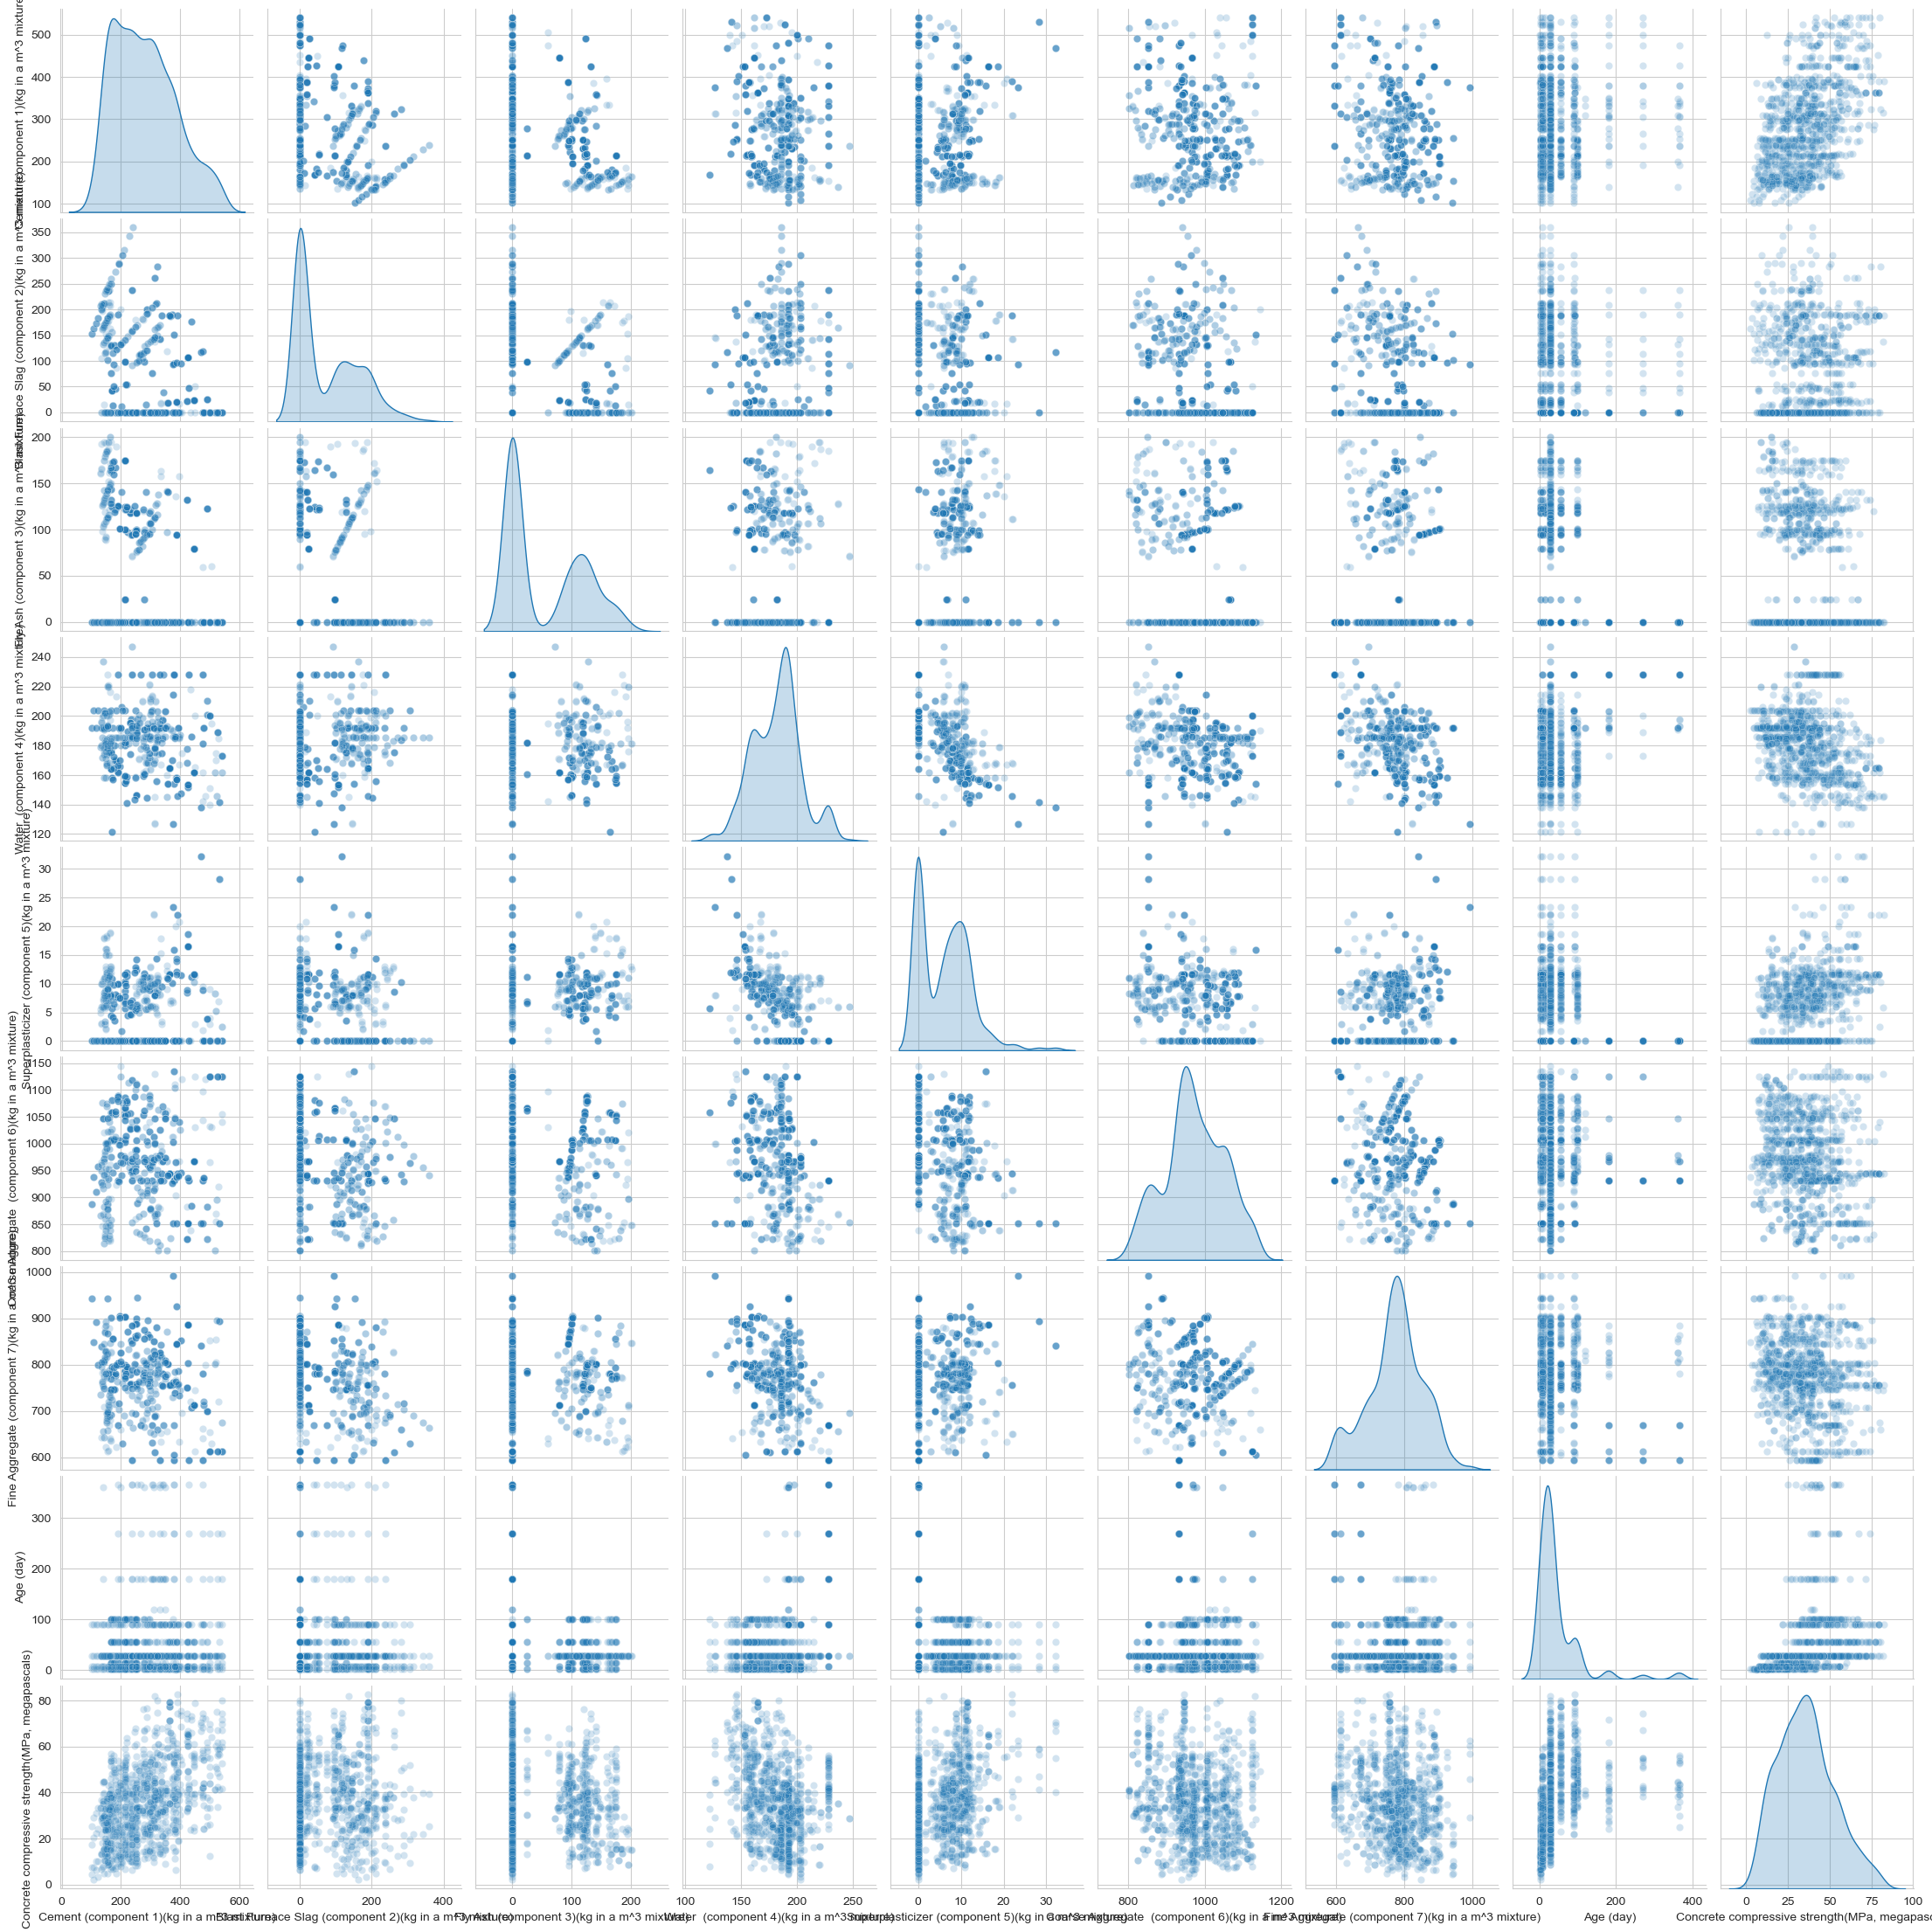

In [2]:
import seaborn as sns

sns.pairplot(ds,diag_kind='kde',plot_kws={'alpha': .2});

In [3]:
# shuffle data
data = ds.values[np.random.permutation(np.arange(len(ds.values)))]

in_dim, out_dim = data.shape[1] - 1, 1

X, y = data[:, :in_dim], data[:, in_dim:]

# normalize and center data
X_means, X_stds = X.mean(axis=0), X.std(axis=0)
y_means, y_stds = y.mean(axis=0), y.std(axis=0)
X = (X - X_means)/X_stds
y = (y - y_means)/y_stds

#### 5 Fold Cross Validation for Linear Regression

In [4]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)
# We use negative mean squared error as score because sklearn expects a score, not a loss
score = cross_val_score(linear_model.LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {-score}')

print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.35920266 0.48498107 0.32336825 0.39663624 0.44209331]
Avg MSE = 0.40


#### 5 Fold Cross Validation for Decision Tree

In [5]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.17575592 0.15229361 0.15548217 0.13379323 0.20578633]
Avg MSE = 0.16


#### 5 Fold Cross Validation for Random Forest

In [6]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.07347865 0.09790772 0.05984279 0.07222424 0.10810282]
Avg MSE = 0.08


#### 5 Fold Cross for Hyper param optimization of Decision Tree

In [7]:
max_depth = [1,5,10,20,50,100]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For max depth: 1
Avg MSE = 0.76
For max depth: 5
Avg MSE = 0.26
For max depth: 10
Avg MSE = 0.17
For max depth: 20
Avg MSE = 0.17
For max depth: 50
Avg MSE = 0.16
For max depth: 100
Avg MSE = 0.16


#### 5 Fold Cross for Hyper param optimization of Random Forest

In [8]:
estimators = [10, 50, 100, 150, 200, 250, 300]

for count in estimators:
    score = cross_val_score(ensemble.RandomForestRegressor(n_estimators= count, random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For estimators: 10
Avg MSE = 0.10
For estimators: 50
Avg MSE = 0.08
For estimators: 100
Avg MSE = 0.08
For estimators: 150
Avg MSE = 0.08
For estimators: 200
Avg MSE = 0.08
For estimators: 250
Avg MSE = 0.08
For estimators: 300
Avg MSE = 0.08


#### NN Regressor

In [9]:
from torch import nn

class NNRegressor(nn.Module):
    def __init__(self, layers=[20,30,20], n_features=8, activation=nn.ReLU):
        super().__init__()
        self.layers = []
        self.activation_functions = []

        self.layers.append(nn.Linear(n_features, layers[0]))
        self.activation_functions.append(activation())
        self.add_module(f"layer{0}", self.layers[-1])
        self.add_module(f"act{0}", self.activation_functions[-1])

        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(self.layers[-1].out_features, layers[i]))
            self.activation_functions.append(activation())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.activation_functions[-1])

        self.output = nn.Linear(self.layers[-1].out_features, 1)

    def forward(self, x):
        for layer, act in zip(self.layers, self.activation_functions):
            x=act(layer(x))

        x = self.output(x)
        return x

#### Grid search hyper param optimization for NN

In [10]:
from sklearn.model_selection import GridSearchCV
from torch import optim
from skorch import NeuralNetRegressor

param_grid = {
    'optimizer': [optim.Adam, optim.Adamax, optim.NAdam],
    'module__activation': [nn.Identity, nn.ReLU, nn.GELU, nn.Tanh, nn.Sigmoid],
    'batch_size': [10, 25, 50],
    'module__layers': [[10,20,10],[30,20,10],[30,30,30]],
    'lr': [0.0001, 0.001, 0.01],
}

grid = GridSearchCV(
    estimator = NeuralNetRegressor(module=NNRegressor),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 3,
    error_score = 'raise',
    return_train_score = True,
    verbose = 0,
    scoring = 'neg_mean_squared_error'
)

In [11]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

grid.fit(X_tensor, y_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0502        1.1618  0.0571
      2        1.0131        1.1280  0.0248
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0546        0.9924  0.0606
      3        0.9804        1.0962  0.0437
      4        0.9494        1.0645  0.0241
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9458        1.0896  0.0722
      2        1.0071        0.9526  0.0288
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0249        0.9033  0.0582
      5        0.9184        1.0312  0.0349
      3        0.9597        0.9116  0.0347
      2        0.9241        1.0651  0.0466
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0130        0.9041  0.0568
  epoch    train_loss    valid_l

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.NNRegressor'>,
),
             n_jobs=-1,
             param_grid={'batch_size': [10, 25, 50],
                         'lr': [0.0001, 0.001, 0.01],
                         'module__activation': [<class 'torch.nn.modules.linear.Identity'>,
                                                <class 'torch.nn.modules.activation.ReLU'>,
                                                <class 'torch.nn.modules.activation.GELU'>,
                                                <class 'torch.nn.modules.activation.Tanh'>,
                                                <class 'torch.nn.modules.activation.Sigmoid'>],
                         'module__layers': [[10, 20, 10], [30, 20, 10],
                                            [30, 30, 30]],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.adamax.Adamax'>,
                                       <class 'torch.optim.nadam.NAdam'>]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [12]:
print("Best params:")
grid.best_params_

Best params:


{'batch_size': 50,
 'lr': 0.01,
 'module__activation': torch.nn.modules.activation.GELU,
 'module__layers': [30, 30, 30],
 'optimizer': torch.optim.adam.Adam}

In [13]:
print(f'Best MSE = {"{:.2f}".format(-grid.best_score_)}')

Best MSE = 0.14


# Results
The best model is the Random Forest with at least 50 estimators. The avarage MSE for the model is 0.08